<a href="https://colab.research.google.com/github/chriztaka1997/linear_reg_sentimental_analysis/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initializing project

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd

import time

#for google access
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
project_path = "/content/drive/My Drive/CSCI_534 Project/Project"
# project_path = './'

amc_stock = pd.read_csv(project_path+'/AMC Stock Data.csv') #181 of sample
amc_vader = pd.read_csv(project_path+'/amc_vader.csv',index_col=0) #108817 of samples

gm_stock = pd.read_csv(project_path+'/Gamestop Stock Data.csv') #181 of sample
gm_vader = pd.read_csv(project_path+'/gamestop_vader.csv',index_col=0) #926877 of samples
gm_vader = gm_vader.dropna(subset=['Datetime','Text','scores'])

nokia_stock = pd.read_csv(project_path+'/Nokia Stock Data.csv') #181 of sample
nokia_vader = pd.read_csv(project_path+'/nokia_vader.csv',index_col=0) #134351 of samples
nokia_vader = nokia_vader.dropna(subset=['Datetime','Text','scores'])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
amc_vader.shape #108817
gm_vader.shape #498125
nokia_vader.shape #134350

(134350, 7)

In [ ]:
gm_vader.head()

,Datetime,Tweet Id,Text,Username,text_clean,scores,compound
0,2021-01-21 23:59:38+00:00,1352405524852174858,Bought the PS5 bundle from @GameStop that tota...,Dr__Hankey,Bought the PS5 bundle from that totaled 800 an...,"{'neg': 0.064, 'neu': 0.675, 'pos': 0.262, 'co...",0.7930
1,2021-01-21 23:59:25+00:00,1352405472779726848,@Entralized @GameStop What phone do you have? 😂,themichaelmsc,What phone do you have 😂,"{'neg': 0.139, 'neu': 0.584, 'pos': 0.277, 'co...",0.4404
2,2021-01-21 23:59:23+00:00,1352405460964540419,@ManyFacedHeel @GameStop That is you after you...,OutlawRobS,That is you after you get and open the box,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3,2021-01-21 23:59:06+00:00,1352405392001794048,@CJSTRO13 Boy GameStop looked out when nobody ...,GumboGoon,Boy GameStop looked out when nobody else did 😭,"{'neg': 0.237, 'neu': 0.763, 'pos': 0.0, 'comp...",-0.4767
4,2021-01-21 23:58:50+00:00,1352405324024655873,"Amazon, Best Buy, and GameStop Release New PS5...",ISIS_Slay3r,Amazon Best Buy and GameStop Release New PS5 S...,"{'neg': 0.111, 'neu': 0.579, 'pos': 0.311, 'co...",0.5859


# Preparing data
In this part, we will combine and prepare the data is neccessary for the model to learn such as date, stock price and vader scores.

Preparing data for AMC

In [ ]:
#In this part we are preparing data for processing (taking datetime and scores from vader data)
amc_vader_date = amc_vader['Datetime'].to_numpy()
amc_vader_scores = amc_vader['scores'].to_numpy()

gm_vader_date = gm_vader['Datetime'].to_numpy()
gm_vader_scores = gm_vader['scores'].to_numpy()

nokia_vader_date = nokia_vader["Datetime"].to_numpy()
nokia_vader_scores = nokia_vader['scores'].to_numpy()

NEG = 1
NEU = 3
POS = 5
COM = -1 #remove '}'

In [ ]:
#Cleaning amc data
amc_vader_neg =[]
amc_vader_neu =[]
amc_vader_pos =[]
amc_vader_com =[] #don't know if needed
for i in range(len(amc_vader_date)):
  amc_vader_date[i] = amc_vader_date[i].split()[0]    #cleaning the data only the date
  #change date fromat
  #mm/dd/yyy
  amc_vader_date[i]=time.strptime(amc_vader_date[i],'%Y-%m-%d') 
  amc_vader_date[i]=time.strftime('%m/%d/%Y',amc_vader_date[i])

  res = amc_vader_scores[i].replace(',','').split()
  amc_vader_neg.append(float(res[NEG]))
  amc_vader_neu.append(float(res[NEU]))
  amc_vader_pos.append(float(res[POS]))
  amc_vader_com.append(float(res[COM].replace("}","")))


In [ ]:
#put amc vader data in df
amc_vader_df = pd.DataFrame({
    'Date':amc_vader_date,
    'neg':amc_vader_neg,
    'neu':amc_vader_neu,
    'pos':amc_vader_pos,
    'com':amc_vader_com
})
#combine data on the same date(caculate the mean of "neg","neu","pos","com")
amc_vader_df=amc_vader_df.groupby(['Date']).agg({'neg':np.mean,'neu':np.mean,'pos':np.mean,'com':np.mean}).reset_index()
# amc_vader_df

In [ ]:
#clean the stock date(taking datetime and close from stock data)
amc_stock_date = amc_stock['Date'].to_numpy()
amc_stock_close = amc_stock['Close'].to_numpy()

In [ ]:
#get stock date and change format
for i in range(len(amc_stock_date)):
  amc_stock_date[i] = amc_stock_date[i].split()[0]
  amc_stock_date[i]=time.strptime(amc_stock_date[i],'%m/%d/%Y')
  amc_stock_date[i]=time.strftime('%m/%d/%Y',amc_stock_date[i])

In [ ]:
#put amc stock data in df
amc_stock_df = pd.DataFrame({
    'Date':amc_stock_date,
    'close':amc_stock_close
})
amc_stock_df

,Date,close
0,07/01/2020,4.57
1,07/02/2020,4.53
2,07/06/2020,4.28
3,07/07/2020,4.13
4,07/08/2020,4.43
...,...,...
176,03/15/2021,14.04
177,03/16/2021,13.02
178,03/17/2021,13.56
179,03/18/2021,14.00


In [ ]:
#merge vader data and stock data
amc_merge_df = pd.merge(amc_vader_df,amc_stock_df,on='Date',how="left")
amc_merge_df = amc_merge_df.dropna().reset_index(drop=True)
amc_merge_df.shape #Only 20 days worth of data

(20, 6)

In [ ]:
amc_merge_df.head()

,Date,neg,neu,pos,com,close
0,01/15/2021,0.051717,0.854198,0.094094,0.157303,2.33
1,01/19/2021,0.032056,0.867944,0.100011,0.209043,3.06
2,01/20/2021,0.030589,0.891189,0.078221,0.155343,2.97
3,01/21/2021,0.036168,0.891655,0.072177,0.084737,2.98
4,01/22/2021,0.060273,0.862308,0.077420,0.048788,3.51


Preparing data for game stop

In [ ]:
#same thing for game stop
gm_vader_neg =[]
gm_vader_neu =[]
gm_vader_pos =[]
gm_vader_com =[] #don't know if needed

for i in range(len(gm_vader_date)):
  gm_vader_date[i] = gm_vader_date[i].split()[0]    #cleaning the data only the date
  #change date fromat
  #mm/dd/yyy
  gm_vader_date[i]=time.strptime(gm_vader_date[i],'%Y-%m-%d') 
  gm_vader_date[i]=time.strftime('%m/%d/%Y',gm_vader_date[i])

  res = gm_vader_scores[i].replace(',','').split()
  gm_vader_neg.append(float(res[NEG]))
  gm_vader_neu.append(float(res[NEU]))
  gm_vader_pos.append(float(res[POS]))
  gm_vader_com.append(float(res[COM].replace("}","")))



In [ ]:
#put amc vader data in df
gm_vader_df = pd.DataFrame({
    'Date':gm_vader_date,
    'neg':gm_vader_neg,
    'neu':gm_vader_neu,
    'pos':gm_vader_pos,
    'com':gm_vader_com
})
#combine data on the same date(caculate the mean of "neg","neu","pos","com")
gm_vader_df=gm_vader_df.groupby(['Date']).agg({'neg':np.mean,'neu':np.mean,'pos':np.mean,'com':np.mean}).reset_index()

#clean the stock date(taking datetime and close from stock data)
gm_stock_date = amc_stock['Date'].to_numpy()
gm_stock_close = amc_stock['Close'].to_numpy()

#get stock date and change format
for i in range(len(amc_stock_date)):
  gm_stock_date[i] = gm_stock_date[i].split()[0]
  gm_stock_date[i]=time.strptime(gm_stock_date[i],'%m/%d/%Y')
  gm_stock_date[i]=time.strftime('%m/%d/%Y',gm_stock_date[i])

#put gm stock data in df
gm_stock_df = pd.DataFrame({
    'Date':gm_stock_date,
    'close':gm_stock_close
})

#merge vader data and stock data
gm_merge_df = pd.merge(gm_vader_df,gm_stock_df,on='Date',how="left")
gm_merge_df = gm_merge_df.dropna().reset_index(drop=True)

In [ ]:
gm_merge_df.shape
gm_merge_df

,Date,neg,neu,pos,com,close
0,01/15/2021,0.066918,0.809479,0.114419,0.119682,2.33
1,01/19/2021,0.071715,0.816464,0.103075,0.096117,3.06
2,01/20/2021,0.070932,0.775153,0.103937,0.077671,2.97
3,01/21/2021,0.101333,0.766235,0.104481,0.035536,2.98
4,01/29/2021,0.074667,0.837049,0.086788,0.042666,13.26
5,02/01/2021,0.068167,0.834893,0.090908,0.073608,13.30
6,02/02/2021,0.032565,0.925680,0.040680,0.026736,7.82
7,02/03/2021,0.066043,0.850344,0.081206,0.047915,8.97
8,02/04/2021,0.008576,0.980081,0.010847,0.007074,7.09
9,02/05/2021,0.064019,0.847752,0.084401,0.065945,6.83


Preparing data for nokia

In [ ]:
#same thing for nokia
#Cleaning nokia data
nokia_vader_neg =[]
nokia_vader_neu =[]
nokia_vader_pos =[]
nokia_vader_com =[] #don't know if needed

exception_nokia =[]
for i in range(len(nokia_vader_date)):
  nokia_vader_date[i] = nokia_vader_date[i].split()[0]    #cleaning the data only the date
  #change date fromat
  #mm/dd/yyy
  nokia_vader_date[i]=time.strptime(nokia_vader_date[i],'%Y-%m-%d') 
  nokia_vader_date[i]=time.strftime('%m/%d/%Y',nokia_vader_date[i])

  res = nokia_vader_scores[i].replace(',','').split()
  nokia_vader_neg.append(float(res[NEG]))
  nokia_vader_neu.append(float(res[NEU]))
  nokia_vader_pos.append(float(res[POS]))
  nokia_vader_com.append(float(res[COM].replace("}","")))


In [ ]:
#put nokia vader data in df
nokia_vader_df = pd.DataFrame({
    'Date':nokia_vader_date,
    'neg':nokia_vader_neg,
    'neu':nokia_vader_neu,
    'pos':nokia_vader_pos,
    'com':nokia_vader_com
})

#combine data on the same date(caculate the mean of "neg","neu","pos","com")
nokia_vader_df=nokia_vader_df.groupby(['Date']).agg({'neg':np.mean,'neu':np.mean,'pos':np.mean,'com':np.mean}).reset_index()

#clean the stock date(taking datetime and close from stock data)
nokia_stock_date = nokia_stock['Date'].to_numpy()
nokia_stock_close = nokia_stock['Close'].to_numpy()

#get stock date and change format
for i in range(len(amc_stock_date)):
  nokia_stock_date[i] = nokia_stock_date[i].split()[0]
  nokia_stock_date[i]=time.strptime(nokia_stock_date[i],'%m/%d/%Y')
  nokia_stock_date[i]=time.strftime('%m/%d/%Y',nokia_stock_date[i])

#put nokia stock data in df
nokia_stock_df = pd.DataFrame({
    'Date':nokia_stock_date,
    'close':nokia_stock_close
})

#merge vader data and stock data
nokia_merge_df = pd.merge(nokia_vader_df,nokia_stock_df,on='Date',how="left")
nokia_merge_df = nokia_merge_df.dropna().reset_index(drop=True)

In [ ]:
nokia_merge_df.shape

(20, 6)

# Training the linear model

Training the linear model for AMC

In [ ]:
#Creating a model based on the amc data
#amc_merge_df[['neg','neu','pos','com']] is the data or x or feature
#amc_merge_df[['close']] is the label
reg_amc = LinearRegression().fit(amc_merge_df[['neg','neu','pos','com']], amc_merge_df[['close']])

Training the linear model for Game Stop

In [ ]:
# similar with the one above but with gm data
reg_gm = LinearRegression().fit(gm_merge_df[['neg','neu','pos','com']], gm_merge_df[['close']])

Training the linear model for Nokia

In [ ]:
#similar with the one above but with nokia data
reg_nokia = LinearRegression().fit(nokia_merge_df[['neg','neu','pos','com']], nokia_merge_df[['close']])

# Plot the data and model of for each company

In [ ]:
#each model is predicting the label using the data that we have
#pred_amc is a numpy array consisting the values of prediction of the amc data that we use for the training
pred_amc = reg_amc.predict(amc_merge_df[['neg','neu','pos','com']])
pred_gm = reg_gm.predict(gm_merge_df[['neg','neu','pos','com']])
pred_nokia = reg_nokia.predict(nokia_merge_df[['neg','neu','pos','com']])

#In this part, I am combining the data  of each company with the prediction
amc_merge_pred = pd.concat([amc_merge_df, pd.DataFrame(pred_amc,columns=['pred'])], axis=1)
gm_merge_pred = pd.concat([gm_merge_df, pd.DataFrame(pred_gm,columns=['pred'])], axis=1)
nokia_merge_pred = pd.concat([nokia_merge_df, pd.DataFrame(pred_nokia,columns=['pred'])], axis=1)

Display the perfomance of the model

In [ ]:
from sklearn.metrics import mean_squared_error

#This is the score of the prediction/ performance of the model
amc_score = mean_squared_error(amc_merge_df[['close']], pred_amc)
gm_score = mean_squared_error(gm_merge_df[['close']], pred_gm)
nokia_score = mean_squared_error(nokia_merge_df[['close']], pred_nokia)
[amc_score, gm_score,nokia_score]

[14.005504752790852, 7.002529792869479, 0.1291994204660292]

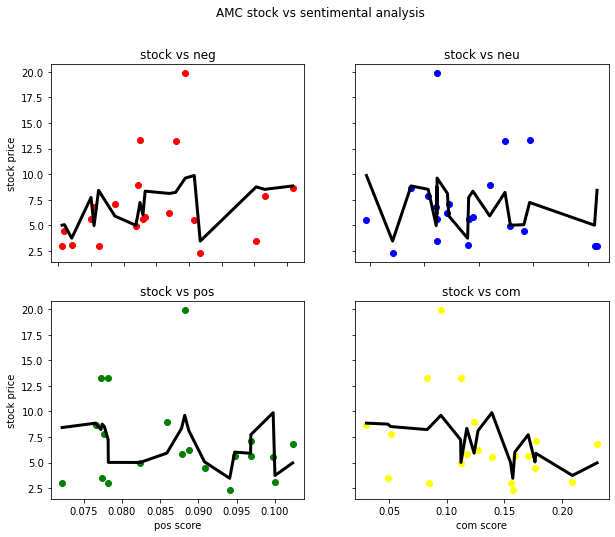

In [ ]:
#plot amc
#In this part, it is plotting the data with the stock + the model itself
fig, axs = plt.subplots(2,2)
fig.suptitle('AMC stock vs sentimental analysis')
fig.set_size_inches(10,8)

amc_sort_neg = amc_merge_pred.sort_values(by=['neg'])
axs[0,0].scatter(amc_sort_neg[['neg']],amc_sort_neg[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(amc_sort_neg[['neg']], amc_sort_neg[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')
axs[0,0].label_outer()

amc_sort_neu = amc_merge_pred.sort_values(by=['neu'])
axs[0,1].scatter(amc_sort_neu[['neu']],amc_sort_neu[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(amc_sort_neu[['neu']], amc_sort_neu[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')
axs[0,1].label_outer()

amc_sort_pos = amc_merge_pred.sort_values(by=['pos'])
axs[1,0].scatter(amc_sort_pos[['pos']],amc_sort_pos[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(amc_sort_pos[['pos']], amc_sort_pos[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')
axs[1,0].label_outer()

amc_sort_com = amc_merge_pred.sort_values(by=['com'])
axs[1,1].scatter(amc_sort_com[['com']],amc_sort_com[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(amc_sort_com[['com']], amc_sort_com[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
axs[1,1].label_outer()


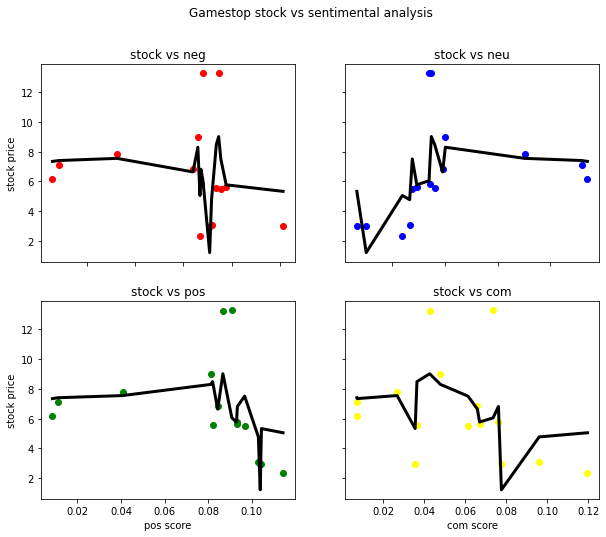

In [ ]:
#plot gm
fig, axs = plt.subplots(2,2)
fig.suptitle('Gamestop stock vs sentimental analysis')
fig.set_size_inches(10,8)

gm_sort_neg = gm_merge_pred.sort_values(by=['neg'])
axs[0,0].scatter(gm_sort_neg[['neg']],gm_sort_neg[['close']],color='red',label='neg')
axs[0,0].plot(gm_sort_neg[['neg']], gm_sort_neg[['pred']], color='black', linewidth=3)
axs[0,0].set_title('stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')
axs[0,0].label_outer()

gm_sort_neu = gm_merge_pred.sort_values(by=['neu'])
axs[0,1].scatter(gm_sort_neu[['neu']],gm_sort_neu[['close']],color='blue',label='neu')
axs[0,1].plot(gm_sort_neu[['neu']], gm_sort_neu[['pred']], color='black', linewidth=3)
axs[0,1].set_title('stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')
axs[0,1].label_outer()

gm_sort_pos = gm_merge_pred.sort_values(by=['pos'])
axs[1,0].scatter(gm_sort_pos[['pos']],gm_sort_pos[['close']],color='green',label='pos')
axs[1,0].plot(gm_sort_pos[['pos']], gm_sort_pos[['pred']], color='black', linewidth=3)
axs[1,0].set_title('stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')
axs[1,0].label_outer()

gm_sort_com = gm_merge_pred.sort_values(by=['com'])
axs[1,1].scatter(gm_sort_com[['com']],gm_sort_com[['close']],color='yellow',label='com')
axs[1,1].plot(gm_sort_com[['com']], gm_sort_com[['pred']], color='black', linewidth=3)
axs[1,1].set_title('stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
axs[1,1].label_outer()

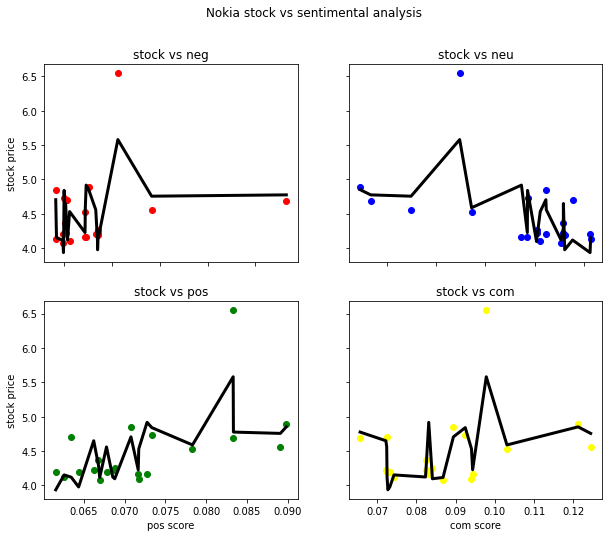

In [ ]:
#plot Nokia
fig, axs = plt.subplots(2,2)
fig.suptitle('Nokia stock vs sentimental analysis')
fig.set_size_inches(10,8)

nokia_sort_neg = nokia_merge_pred.sort_values(by=['neg'])
axs[0,0].scatter(nokia_sort_neg[['neg']],nokia_sort_neg[['close']],color='red',label='neg')
axs[0,0].plot(nokia_sort_neg[['neg']], nokia_sort_neg[['pred']], color='black', linewidth=3)
axs[0,0].set_title('stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')
axs[0,0].label_outer()

nokia_sort_neu = nokia_merge_pred.sort_values(by=['neu'])
axs[0,1].scatter(nokia_sort_neu[['neu']],nokia_sort_neu[['close']],color='blue',label='neu')
axs[0,1].plot(nokia_sort_neu[['neu']], nokia_sort_neu[['pred']], color='black', linewidth=3)
axs[0,1].set_title('stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')
axs[0,1].label_outer()

nokia_sort_pos = nokia_merge_pred.sort_values(by=['pos'])
axs[1,0].scatter(nokia_sort_pos[['pos']],nokia_sort_pos[['close']],color='green',label='pos')
axs[1,0].plot(nokia_sort_pos[['pos']], nokia_sort_pos[['pred']], color='black', linewidth=3)
axs[1,0].set_title('stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')
axs[1,0].label_outer()

nokia_sort_com = nokia_merge_pred.sort_values(by=['com'])
axs[1,1].scatter(nokia_sort_com[['com']],nokia_sort_com[['close']],color='yellow',label='com')
axs[1,1].plot(nokia_sort_com[['com']], nokia_sort_com[['pred']], color='black', linewidth=3)
axs[1,1].set_title('stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
axs[1,1].label_outer()

# Plot data against time

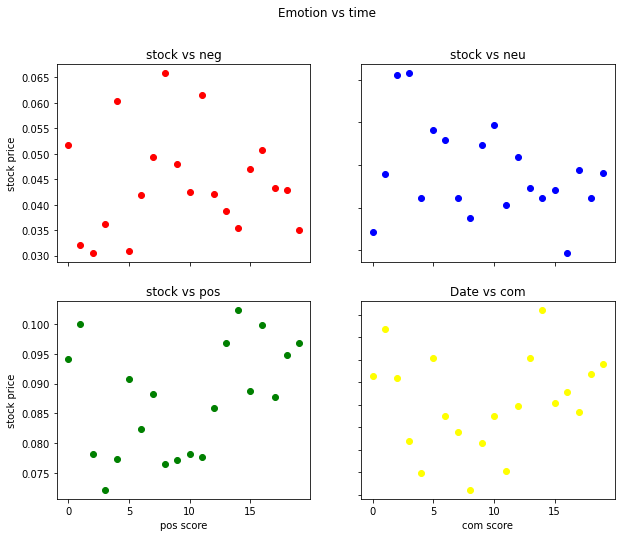

In [ ]:
fig, axs = plt.subplots(2,2)
fig.suptitle('Emotion vs time')
fig.set_size_inches(10,8)

amc_sort_neg = amc_merge_pred.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(20)],amc_sort_neg[['neg']],color='red',label='neg')
axs[0,0].set_title('stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')
axs[0,0].label_outer()

amc_sort_neu = amc_merge_pred.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(20)],amc_sort_neu[['neu']],color='blue',label='neu')
axs[0,1].set_title('stock vs neu')
axs[0,1].set(xlabel='Date', ylabel='neu value')
axs[0,1].label_outer()

amc_sort_pos = amc_merge_pred.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(20)],amc_sort_pos[['pos']],color='green',label='pos')
axs[1,0].set_title('stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')
axs[1,0].label_outer()

amc_sort_com = amc_merge_pred.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(20)],amc_sort_com[['com']],color='yellow',label='com')
axs[1,1].set_title('Date vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
axs[1,1].label_outer()

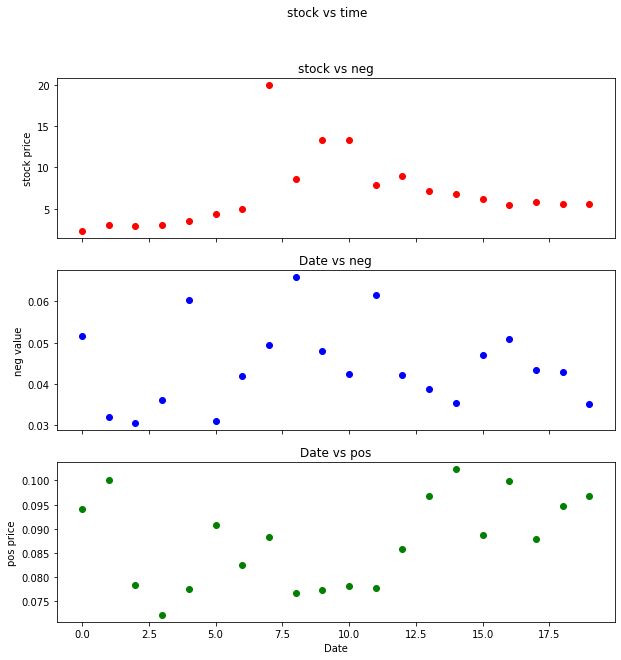

In [ ]:
fig, axs = plt.subplots(3)
fig.set_size_inches(10,10)
fig.suptitle('stock vs time')

amc_sort_neg = amc_merge_pred.sort_values(by=['Date'])
axs[0].scatter([i for i in range(20)],amc_sort_neg[['close']],color='red',label='neg')
axs[0].set_title('stock vs neg')
axs[0].set(xlabel='neg score', ylabel='stock price')
axs[0].label_outer()

amc_sort_neu = amc_merge_pred.sort_values(by=['Date'])
axs[1].scatter([i for i in range(20)],amc_sort_neu[['neg']],color='blue',label='neu')
axs[1].set_title('Date vs neg')
axs[1].set(xlabel='Date', ylabel='neg value')
axs[1].label_outer()

amc_sort_pos = amc_merge_pred.sort_values(by=['Date'])
axs[2].scatter([i for i in range(20)],amc_sort_pos[['pos']],color='green',label='pos')
axs[2].set_title('Date vs pos')
axs[2].set(xlabel='Date', ylabel='pos price')
plt.show()

# Training with different method

In [ ]:
#Training models based on the amc data for four features(neg,neu,pos,com) separately
reg_amc_neg = LinearRegression().fit(amc_merge_df[['neg']], amc_merge_df[['close']])
reg_amc_neu = LinearRegression().fit(amc_merge_df[['neu']], amc_merge_df[['close']])
reg_amc_pos = LinearRegression().fit(amc_merge_df[['pos']], amc_merge_df[['close']])
reg_amc_com = LinearRegression().fit(amc_merge_df[['com']], amc_merge_df[['close']])

In [ ]:
#predict the stock price of amc using new models
pred_amc_neg = reg_amc_neg.predict(amc_merge_df[['neg']])
pred_amc_neu = reg_amc_neu.predict(amc_merge_df[['neu']])
pred_amc_pos = reg_amc_pos.predict(amc_merge_df[['pos']])
pred_amc_com = reg_amc_com.predict(amc_merge_df[['com']])

#combine five kinds of prediction for amc with original data
amc_merge_pred1 = pd.concat([amc_merge_df, pd.DataFrame(pred_amc,columns=['pred'])], axis=1)
amc_merge_pred1 = pd.concat([amc_merge_pred1, pd.DataFrame(pred_amc_neg,columns=['pred_neg'])], axis=1)
amc_merge_pred1 = pd.concat([amc_merge_pred1, pd.DataFrame(pred_amc_neu,columns=['pred_neu'])], axis=1)
amc_merge_pred1 = pd.concat([amc_merge_pred1, pd.DataFrame(pred_amc_pos,columns=['pred_pos'])], axis=1)
amc_merge_pred1 = pd.concat([amc_merge_pred1, pd.DataFrame(pred_amc_com,columns=['pred_com'])], axis=1)

amc_merge_pred1

,Date,neg,neu,pos,com,close,pred,pred_neg,pred_neu,pred_pos,pred_com
0,01/15/2021,0.051717,0.854198,0.094094,0.157303,2.33,3.454731,7.742069,7.439257,6.399701,6.188660
1,01/19/2021,0.032056,0.867944,0.100011,0.209043,3.06,3.732285,5.600078,6.951304,5.933147,4.868944
2,01/20/2021,0.030589,0.891189,0.078221,0.155343,2.97,5.010516,5.440358,6.126176,7.651354,6.238644
3,01/21/2021,0.036168,0.891655,0.072177,0.084737,2.98,8.419001,6.048119,6.109656,8.127946,8.039552
4,01/22/2021,0.060273,0.862308,0.077420,0.048788,3.51,8.757406,8.674165,7.151391,7.714553,8.956484
5,01/25/2021,0.030951,0.878253,0.090804,0.176599,4.42,5.062440,5.479731,6.585395,6.659192,5.696494
6,01/26/2021,0.041856,0.875782,0.082374,0.112311,4.96,5.003683,6.667821,6.673093,7.323854,7.336254
7,01/27/2021,0.049433,0.862353,0.088215,0.094885,19.90,9.617352,7.493212,7.149788,6.863312,7.780716
8,01/28/2021,0.065859,0.857587,0.076555,0.030285,8.63,8.847836,9.282718,7.318946,7.782716,9.428435
9,01/29/2021,0.047950,0.874793,0.077256,0.082901,13.26,8.219541,7.331714,6.708213,7.727470,8.086393


In [ ]:
amc_score_neg = mean_squared_error(amc_merge_df[['close']], amc_merge_pred1[['pred_neg']])
amc_score_neu = mean_squared_error(amc_merge_df[['close']], amc_merge_pred1[['pred_neu']])
amc_score_pos = mean_squared_error(amc_merge_df[['close']], amc_merge_pred1[['pred_pos']])
amc_score_com = mean_squared_error(amc_merge_df[['close']], amc_merge_pred1[['pred_com']])
[amc_score_neg,amc_score_neu,amc_score_pos,amc_score_com]

[16.511674608557456, 17.52812044393578, 17.154519701675277, 15.926417280534002]

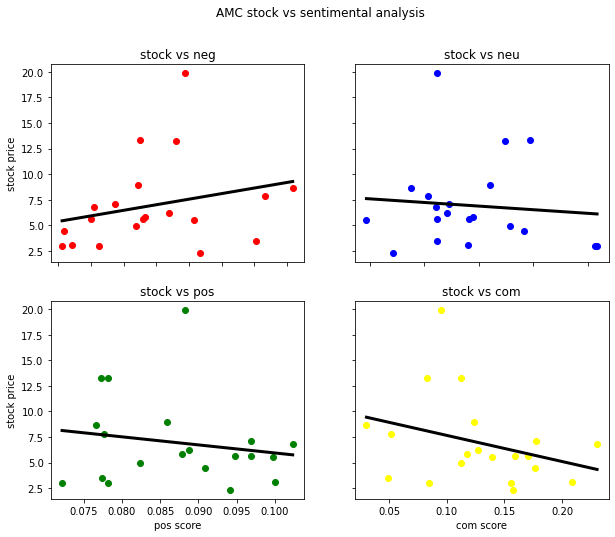

In [ ]:
#plot the new amc model
#In this part, it is plotting the data with the stock + the model itself
fig, axs = plt.subplots(2,2)
fig.suptitle('AMC stock vs sentimental analysis')
fig.set_size_inches(10,8)

amc_sort_neg = amc_merge_pred1.sort_values(by=['neg'])
axs[0,0].scatter(amc_sort_neg[['neg']],amc_sort_neg[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(amc_sort_neg[['neg']], amc_sort_neg[['pred_neg']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')
axs[0,0].label_outer()

amc_sort_neu = amc_merge_pred1.sort_values(by=['neu'])
axs[0,1].scatter(amc_sort_neu[['neu']],amc_sort_neu[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(amc_sort_neu[['neu']], amc_sort_neu[['pred_neu']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')
axs[0,1].label_outer()

amc_sort_pos = amc_merge_pred1.sort_values(by=['pos'])
axs[1,0].scatter(amc_sort_pos[['pos']],amc_sort_pos[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(amc_sort_pos[['pos']], amc_sort_pos[['pred_pos']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')
axs[1,0].label_outer()

amc_sort_com = amc_merge_pred1.sort_values(by=['com'])
axs[1,1].scatter(amc_sort_com[['com']],amc_sort_com[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(amc_sort_com[['com']], amc_sort_com[['pred_com']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
axs[1,1].label_outer()
